In [1]:
# Import required libraries
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import confusion_matrix, mean_absolute_error
import seaborn as sns

# Step 1: Download and Prepare Dataset
# --------------------------------------
# Download UTKFace dataset from Kaggle (requires Kaggle API setup)
# First upload your kaggle.json file if running in Colab
!pip install -q kaggle
from google.colab import files
files.upload()  # Upload your kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d jangedoo/utkface-new
with zipfile.ZipFile('utkface-new.zip', 'r') as zip_ref:
    zip_ref.extractall('utkface')

# Step 2: Dataset Class and Visualization
# ----------------------------------------
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path)

        # Parse filename: age_gender_race_date.jpg
        filename = self.image_files[idx].split('_')
        age = int(filename[0])
        gender = int(filename[1])

        if self.transform:
            image = self.transform(image)

        return image, (age, gender)




cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 96% 319M/331M [00:01<00:00, 219MB/s]
100% 331M/331M [00:01<00:00, 203MB/s]


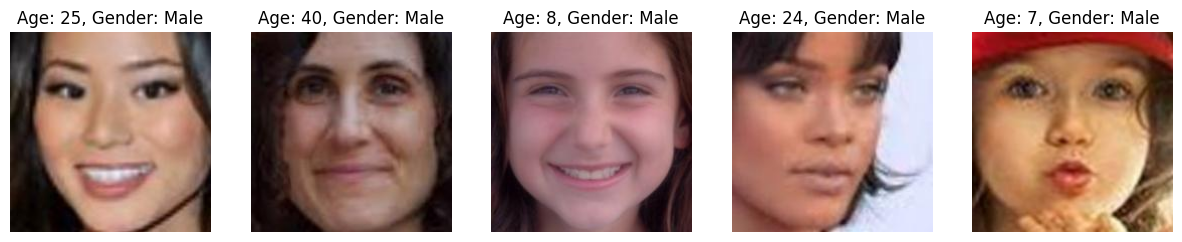

In [16]:
# Visualize sample images
def show_examples(dataset, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        img, (age, gender) = dataset[i]
        label = f"Age: {age}, Gender: {'Male' if gender == 1 else 'Female'}"
        axes[i].imshow(np.array(img))
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

# Create raw dataset instance for visualization
raw_dataset = UTKFaceDataset(root_dir='utkface/UTKFace', transform=None)
show_examples(raw_dataset)

In [17]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create transformed dataset and split
full_dataset = UTKFaceDataset(root_dir='utkface/UTKFace', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [18]:
class MultiTaskModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.age_head = nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
        self.gender_head = nn.Sequential(
            nn.Linear(128 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.base(x)
        age = self.age_head(x)
        gender = self.gender_head(x)
        return age.squeeze(1), gender.squeeze(1)

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel().to(device)

age_criterion = nn.MSELoss()
gender_criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to track metrics
train_metrics = {'age_loss': [], 'gender_loss': [], 'acc': [], 'mae': []}
val_metrics = {'age_loss': [], 'gender_loss': [], 'acc': [], 'mae': []}

In [20]:
for epoch in range(20):
    model.train()
    running_age_loss = 0.0
    running_gender_loss = 0.0
    correct_gender = 0
    total = 0
    mae = 0.0

    for images, (ages, genders) in train_loader:
        images = images.to(device)
        ages = ages.float().to(device)
        genders = genders.float().to(device)

        optimizer.zero_grad()
        age_preds, gender_preds = model(images)

        age_loss = age_criterion(age_preds, ages)
        gender_loss = gender_criterion(gender_preds, genders)
        total_loss = age_loss + gender_loss

        total_loss.backward()
        optimizer.step()

        running_age_loss += age_loss.item()
        running_gender_loss += gender_loss.item()
        correct_gender += ((torch.sigmoid(gender_preds) > 0.5) == genders).sum().item()
        mae += torch.abs(age_preds - ages).sum().item()
        total += ages.size(0)

    # Record training metrics
    train_metrics['age_loss'].append(running_age_loss / len(train_loader))
    train_metrics['gender_loss'].append(running_gender_loss / len(train_loader))
    train_metrics['acc'].append(correct_gender / total)
    train_metrics['mae'].append(mae / total)

    # Validation every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        val_age_loss = 0.0
        val_gender_loss = 0.0
        val_correct = 0
        val_total = 0
        val_mae = 0.0

        with torch.no_grad():
            for images, (ages, genders) in val_loader:
                images = images.to(device)
                ages = ages.float().to(device)
                genders = genders.float().to(device)

                age_preds, gender_preds = model(images)
                val_age_loss += age_criterion(age_preds, ages).item()
                val_gender_loss += gender_criterion(gender_preds, genders).item()
                val_correct += ((torch.sigmoid(gender_preds) > 0.5) == genders).sum().item()
                val_mae += torch.abs(age_preds - ages).sum().item()
                val_total += ages.size(0)

        # Record validation metrics
        val_metrics['age_loss'].append(val_age_loss / len(val_loader))
        val_metrics['gender_loss'].append(val_gender_loss / len(val_loader))
        val_metrics['acc'].append(val_correct / val_total)
        val_metrics['mae'].append(val_mae / val_total)

        print(f'Epoch {epoch+1}: '
              f'Train Loss (Age/Gender): {train_metrics["age_loss"][-1]:.4f}/{train_metrics["gender_loss"][-1]:.4f}, '
              f'Val Loss (Age/Gender): {val_metrics["age_loss"][-1]:.4f}/{val_metrics["gender_loss"][-1]:.4f}')

Epoch 5: Train Loss (Age/Gender): 73.7688/0.1974, Val Loss (Age/Gender): 118.6800/0.2457
Epoch 10: Train Loss (Age/Gender): 31.1049/0.0610, Val Loss (Age/Gender): 78.6650/0.2954
Epoch 15: Train Loss (Age/Gender): 16.1015/0.0248, Val Loss (Age/Gender): 84.4408/0.4152
Epoch 20: Train Loss (Age/Gender): 11.1413/0.0157, Val Loss (Age/Gender): 79.6629/0.5411


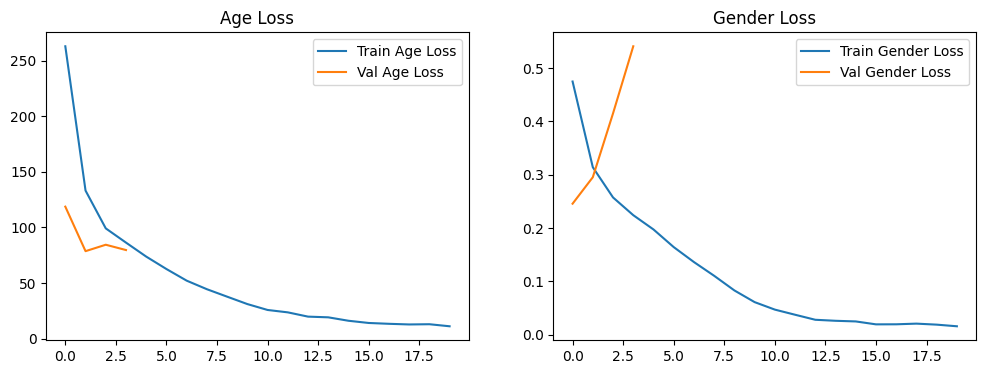

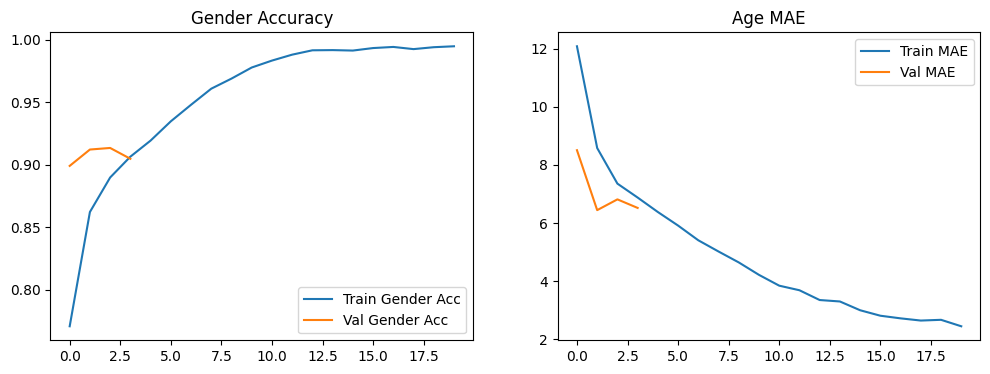

In [21]:
# Plot loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_metrics['age_loss'], label='Train Age Loss')
plt.plot(val_metrics['age_loss'], label='Val Age Loss')
plt.title('Age Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metrics['gender_loss'], label='Train Gender Loss')
plt.plot(val_metrics['gender_loss'], label='Val Gender Loss')
plt.title('Gender Loss')
plt.legend()
plt.show()

# Plot accuracy and MAE
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_metrics['acc'], label='Train Gender Acc')
plt.plot(val_metrics['acc'], label='Val Gender Acc')
plt.title('Gender Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metrics['mae'], label='Train MAE')
plt.plot(val_metrics['mae'], label='Val MAE')
plt.title('Age MAE')
plt.legend()
plt.show()

In [22]:
torch.save(model.state_dict(), 'multi_task_model.pth')


Test Results:
Gender Accuracy: 0.9047
Age MAE: 6.5182


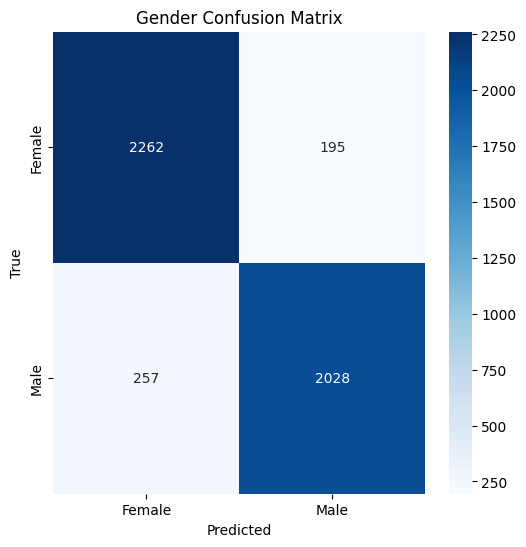

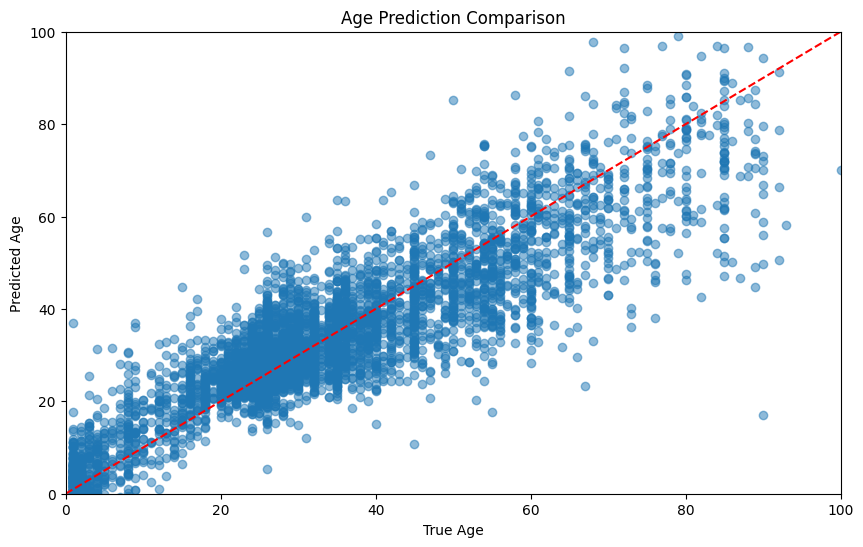

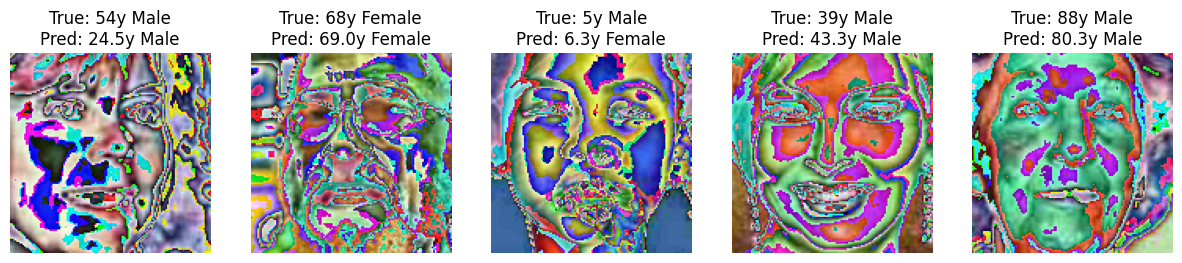

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskModel().to(device)
model.load_state_dict(torch.load('multi_task_model.pth'))
model.eval()

# Test on validation set (replace with proper test set if available)
test_loader = val_loader  # Using validation set as test set for demonstration

# Initialize metrics
test_metrics = {
    'gender_correct': 0,
    'total': 0,
    'mae': 0.0,
    'all_genders': [],
    'pred_genders': [],
    'all_ages': [],
    'pred_ages': []
}

# Testing loop
with torch.no_grad():
    for images, (ages, genders) in test_loader:
        images = images.to(device)
        ages = ages.float().to(device)
        genders = genders.float().to(device)

        age_preds, gender_preds = model(images)

        # Gender metrics
        pred_genders = (torch.sigmoid(gender_preds) > 0.5).float()
        test_metrics['gender_correct'] += (pred_genders == genders).sum().item()

        # Age metrics
        test_metrics['mae'] += torch.abs(age_preds - ages).sum().item()

        # Collect data for visualizations
        test_metrics['all_genders'].extend(genders.cpu().numpy())
        test_metrics['pred_genders'].extend(pred_genders.cpu().numpy())
        test_metrics['all_ages'].extend(ages.cpu().numpy())
        test_metrics['pred_ages'].extend(age_preds.cpu().numpy())

        test_metrics['total'] += ages.size(0)

# Calculate final metrics
accuracy = test_metrics['gender_correct'] / test_metrics['total']
mae = test_metrics['mae'] / test_metrics['total']

print(f'\nTest Results:')
print(f'Gender Accuracy: {accuracy:.4f}')
print(f'Age MAE: {mae:.4f}')

# Confusion matrix for gender
plt.figure(figsize=(6, 6))
cm = confusion_matrix(test_metrics['all_genders'], test_metrics['pred_genders'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Gender Confusion Matrix')
plt.show()

# Age prediction comparison
plt.figure(figsize=(10, 6))
plt.scatter(test_metrics['all_ages'], test_metrics['pred_ages'], alpha=0.5)
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel('True Age')
plt.ylabel('Predicted Age')
plt.title('Age Prediction Comparison')
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.show()

# Show example predictions
def show_test_examples(dataset, num_examples=5):
    indices = np.random.choice(len(dataset), num_examples, replace=False)
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

    for i, idx in enumerate(indices):
        img_tensor, (true_age, true_gender) = dataset[idx]
        img = np.array(transforms.ToPILImage()(img_tensor))

        with torch.no_grad():
            age_pred, gender_pred = model(img_tensor.unsqueeze(0).to(device))

        age_pred = age_pred.item()
        gender_pred = 'Male' if torch.sigmoid(gender_pred) > 0.5 else 'Female'
        true_gender = 'Male' if true_gender == 1 else 'Female'

        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_age}y {true_gender}\n'
                          f'Pred: {age_pred:.1f}y {gender_pred}')
        axes[i].axis('off')
    plt.show()

show_test_examples(val_dataset)